In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import optuna
from sklearn.metrics import jaccard_score

In [7]:
def read_surfer6_grd(file_path):
    with open(file_path, 'r') as f:
        # Проверка формата
        header = f.readline().strip()
        if header != "DSAA":
            raise ValueError("Неверный формат Surfer GRD (ожидается 'DSAA')")

        # Чтение размеров сетки
        Nx, Ny = map(int, f.readline().split())
        
        # Чтение диапазонов X, Y, Z
        xMin, xMax = map(float, f.readline().split())
        yMin, yMax = map(float, f.readline().split())
        zMin, zMax = map(float, f.readline().split())

        # Чтение данных сетки
        grid_data = np.loadtxt(f)  # Автоматически загружает оставшиеся строки
        
        # Проверка размерности
        if grid_data.shape != (Ny, Nx):
            raise ValueError(
                f"Ожидалась сетка {Ny}x{Nx}, но получено {grid_data.shape}"
            )

    return [Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, grid_data]

def write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data, file):
    with open(file, "w") as f:
        f.write("DSAA" + '\n')
        f.write("%s %s" % (Nx, Ny) + '\n')
        f.write("%s %s" % (xMin, xMax) + '\n')
        f.write("%s %s" % (yMin, yMax) + '\n')
        f.write("%s %s" % (zMin, zMax) + '\n')
        for row in data:
            f.write(' '.join([str(t) for t in row]) + '\n')

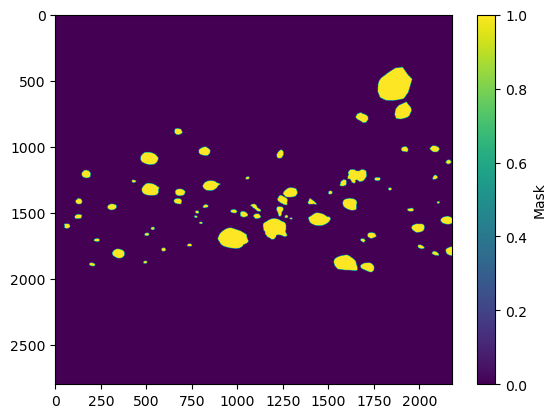

In [13]:
file_manual_path = 'Manual_mask_big.grd'
params = read_surfer6_grd(file_manual_path)

Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data_man = params
data_man[data_man == 1.70141e+38] = 0

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()



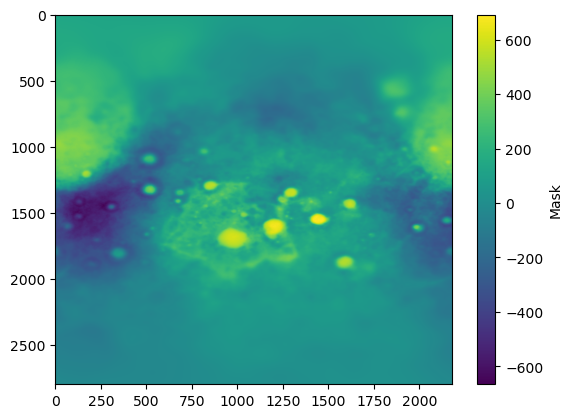

In [9]:
file_path = "dGb255_Merc_dx5km.grd"
params = read_surfer6_grd(file_path)

# Распаковка результатов
Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data = params

plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

data_norm = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

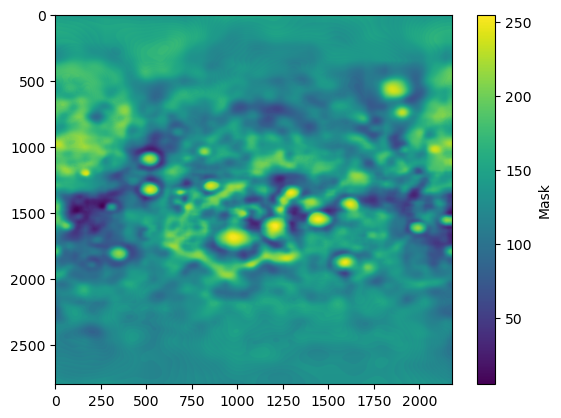

In [11]:
# Подготовка изображения
data_blur = cv2.blur(data_norm, (50, 50))

#CLAHE (адаптивное улучшение контраста)
clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(20, 20))
data_clahe = clahe.apply(data_blur)

plt.imshow(data_clahe, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

In [13]:
from sklearn.metrics import jaccard_score

In [187]:
# 1. Адаптивное пороговое выделение


def objective(trial):
    # boundaries for the optimizer's
    treshold = trial.suggest_int("treshold", 41, 101, step=2) # Погороговое значение
    const = trial.suggest_int("const", 0, 5, step=1) # Константа для adaptive_thresh
    kernel_size_close = trial.suggest_int("kernel_size_close", 1, 31, step=2) # Размер ядра для создания закрытой фигуры
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 1, 31, step=2) # Размер ядра для создания дилатации
    
    # create new model(and all parameters) every iteration
    adaptive_thresh = cv2.adaptiveThreshold(
        data_clahe, 1, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        treshold,  # Размер блока (должен быть нечетным)
        const    # Константа вычитаемая из среднего
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    dilated = cv2.erode(closed, kernel2, iterations=1)
    #filled = closed.copy()
    #contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #cv2.drawContours(filled, contours, -1, 1, thickness=cv2.FILLED)
    
    pred = dilated #filled
   
    error = jaccard_score(
        data_man.flatten(), 
        pred.flatten(), 
        average='binary'  # Для бинарной сегментации
    )
    print(error)
    return error

study = optuna.create_study(direction='maximize')  # Максимизируем IoU
study.optimize(objective, n_trials = 200)  # Количество итераций

[I 2025-04-10 01:06:55,892] A new study created in memory with name: no-name-39d0901e-1421-49f4-a1c5-0218f1fd38bb
[I 2025-04-10 01:06:57,288] Trial 0 finished with value: 0.030447708196399297 and parameters: {'treshold': 75, 'const': 3, 'kernel_size_close': 17, 'kernel_size_dil': 31}. Best is trial 0 with value: 0.030447708196399297.


0.030447708196399297


[I 2025-04-10 01:06:58,678] Trial 1 finished with value: 0.2224568872585489 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 1 with value: 0.2224568872585489.


0.2224568872585489


[I 2025-04-10 01:07:00,093] Trial 2 finished with value: 0.03416283362558606 and parameters: {'treshold': 85, 'const': 3, 'kernel_size_close': 25, 'kernel_size_dil': 11}. Best is trial 1 with value: 0.2224568872585489.


0.03416283362558606


[I 2025-04-10 01:07:01,518] Trial 3 finished with value: 0.03132657497812557 and parameters: {'treshold': 71, 'const': 1, 'kernel_size_close': 29, 'kernel_size_dil': 29}. Best is trial 1 with value: 0.2224568872585489.


0.03132657497812557


[I 2025-04-10 01:07:02,865] Trial 4 finished with value: 0.03145476615581819 and parameters: {'treshold': 45, 'const': 4, 'kernel_size_close': 7, 'kernel_size_dil': 29}. Best is trial 1 with value: 0.2224568872585489.


0.03145476615581819


[I 2025-04-10 01:07:04,253] Trial 5 finished with value: 0.038353750860289054 and parameters: {'treshold': 83, 'const': 1, 'kernel_size_close': 17, 'kernel_size_dil': 11}. Best is trial 1 with value: 0.2224568872585489.


0.038353750860289054


[I 2025-04-10 01:07:05,637] Trial 6 finished with value: 0.0315558704156496 and parameters: {'treshold': 59, 'const': 5, 'kernel_size_close': 9, 'kernel_size_dil': 27}. Best is trial 1 with value: 0.2224568872585489.


0.0315558704156496


[I 2025-04-10 01:07:07,043] Trial 7 finished with value: 0.03331453678537441 and parameters: {'treshold': 83, 'const': 1, 'kernel_size_close': 29, 'kernel_size_dil': 25}. Best is trial 1 with value: 0.2224568872585489.


0.03331453678537441


[I 2025-04-10 01:07:08,441] Trial 8 finished with value: 0.03240991993961953 and parameters: {'treshold': 67, 'const': 5, 'kernel_size_close': 31, 'kernel_size_dil': 5}. Best is trial 1 with value: 0.2224568872585489.


0.03240991993961953


[I 2025-04-10 01:07:09,894] Trial 9 finished with value: 0.04092395868682129 and parameters: {'treshold': 91, 'const': 0, 'kernel_size_close': 25, 'kernel_size_dil': 3}. Best is trial 1 with value: 0.2224568872585489.


0.04092395868682129


[I 2025-04-10 01:07:11,305] Trial 10 finished with value: 0.19389923989387386 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 1 with value: 0.2224568872585489.


0.19389923989387386


[I 2025-04-10 01:07:12,703] Trial 11 finished with value: 0.19389923989387386 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 1 with value: 0.2224568872585489.


0.19389923989387386


[I 2025-04-10 01:07:14,153] Trial 12 finished with value: 0.14975674533711594 and parameters: {'treshold': 53, 'const': 2, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 1 with value: 0.2224568872585489.


0.14975674533711594


[I 2025-04-10 01:07:15,575] Trial 13 finished with value: 0.08694457206406737 and parameters: {'treshold': 51, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 1 with value: 0.2224568872585489.


0.08694457206406737


[I 2025-04-10 01:07:16,988] Trial 14 finished with value: 0.03363847385235037 and parameters: {'treshold': 59, 'const': 2, 'kernel_size_close': 13, 'kernel_size_dil': 7}. Best is trial 1 with value: 0.2224568872585489.


0.03363847385235037


[I 2025-04-10 01:07:18,406] Trial 15 finished with value: 0.29347981555771996 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 15 with value: 0.29347981555771996.


0.29347981555771996


[I 2025-04-10 01:07:19,890] Trial 16 finished with value: 0.05278227440138889 and parameters: {'treshold': 101, 'const': 1, 'kernel_size_close': 11, 'kernel_size_dil': 23}. Best is trial 15 with value: 0.29347981555771996.


0.05278227440138889


[I 2025-04-10 01:07:21,310] Trial 17 finished with value: 0.04434690443598183 and parameters: {'treshold': 49, 'const': 2, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 15 with value: 0.29347981555771996.


0.04434690443598183


[I 2025-04-10 01:07:22,786] Trial 18 finished with value: 0.057373274473929536 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 1}. Best is trial 15 with value: 0.29347981555771996.


0.057373274473929536


[I 2025-04-10 01:07:24,169] Trial 19 finished with value: 0.03481084821177921 and parameters: {'treshold': 65, 'const': 1, 'kernel_size_close': 21, 'kernel_size_dil': 9}. Best is trial 15 with value: 0.29347981555771996.


0.03481084821177921


[I 2025-04-10 01:07:25,572] Trial 20 finished with value: 0.032135300424142706 and parameters: {'treshold': 47, 'const': 4, 'kernel_size_close': 15, 'kernel_size_dil': 23}. Best is trial 15 with value: 0.29347981555771996.


0.032135300424142706


[I 2025-04-10 01:07:26,922] Trial 21 finished with value: 0.19389923989387386 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 15 with value: 0.29347981555771996.


0.19389923989387386


[I 2025-04-10 01:07:28,250] Trial 22 finished with value: 0.2943030178019951 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 22 with value: 0.2943030178019951.


0.2943030178019951


[I 2025-04-10 01:07:29,630] Trial 23 finished with value: 0.07062850370236408 and parameters: {'treshold': 53, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 22 with value: 0.2943030178019951.


0.07062850370236408


[I 2025-04-10 01:07:30,975] Trial 24 finished with value: 0.29634218179993077 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.29634218179993077


[I 2025-04-10 01:07:32,303] Trial 25 finished with value: 0.06882760181371064 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 9, 'kernel_size_dil': 21}. Best is trial 24 with value: 0.29634218179993077.


0.06882760181371064


[I 2025-04-10 01:07:33,633] Trial 26 finished with value: 0.04086913002867878 and parameters: {'treshold': 55, 'const': 1, 'kernel_size_close': 11, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.04086913002867878


[I 2025-04-10 01:07:34,994] Trial 27 finished with value: 0.09290147823327005 and parameters: {'treshold': 45, 'const': 2, 'kernel_size_close': 3, 'kernel_size_dil': 23}. Best is trial 24 with value: 0.29634218179993077.


0.09290147823327005


[I 2025-04-10 01:07:36,363] Trial 28 finished with value: 0.08334390052050002 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 15}. Best is trial 24 with value: 0.29634218179993077.


0.08334390052050002


[I 2025-04-10 01:07:37,710] Trial 29 finished with value: 0.03345795773212666 and parameters: {'treshold': 75, 'const': 3, 'kernel_size_close': 21, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.03345795773212666


[I 2025-04-10 01:07:39,078] Trial 30 finished with value: 0.14911343822253517 and parameters: {'treshold': 63, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 24 with value: 0.29634218179993077.


0.14911343822253517


[I 2025-04-10 01:07:40,452] Trial 31 finished with value: 0.2653843093570974 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 24 with value: 0.29634218179993077.


0.2653843093570974


[I 2025-04-10 01:07:41,793] Trial 32 finished with value: 0.12313494002968918 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 24 with value: 0.29634218179993077.


0.12313494002968918


[I 2025-04-10 01:07:43,150] Trial 33 finished with value: 0.24414569708519207 and parameters: {'treshold': 57, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 24 with value: 0.29634218179993077.


0.24414569708519207


[I 2025-04-10 01:07:44,473] Trial 34 finished with value: 0.04197696310918209 and parameters: {'treshold': 49, 'const': 1, 'kernel_size_close': 9, 'kernel_size_dil': 11}. Best is trial 24 with value: 0.29634218179993077.


0.04197696310918209


[I 2025-04-10 01:07:45,830] Trial 35 finished with value: 0.29634218179993077 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.29634218179993077


[I 2025-04-10 01:07:47,171] Trial 36 finished with value: 0.09459976686053398 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 24 with value: 0.29634218179993077.


0.09459976686053398


[I 2025-04-10 01:07:48,481] Trial 37 finished with value: 0.031110122049178197 and parameters: {'treshold': 43, 'const': 4, 'kernel_size_close': 5, 'kernel_size_dil': 31}. Best is trial 24 with value: 0.29634218179993077.


0.031110122049178197


[I 2025-04-10 01:07:49,843] Trial 38 finished with value: 0.04018286750339291 and parameters: {'treshold': 53, 'const': 1, 'kernel_size_close': 11, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.04018286750339291


[I 2025-04-10 01:07:51,185] Trial 39 finished with value: 0.1670448488096729 and parameters: {'treshold': 45, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 25}. Best is trial 24 with value: 0.29634218179993077.


0.1670448488096729


[I 2025-04-10 01:07:52,535] Trial 40 finished with value: 0.05041388089851167 and parameters: {'treshold': 79, 'const': 0, 'kernel_size_close': 17, 'kernel_size_dil': 27}. Best is trial 24 with value: 0.29634218179993077.


0.05041388089851167


[I 2025-04-10 01:07:53,904] Trial 41 finished with value: 0.2164911860425711 and parameters: {'treshold': 51, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 24 with value: 0.29634218179993077.


0.2164911860425711


[I 2025-04-10 01:07:55,220] Trial 42 finished with value: 0.2919248112930105 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.2919248112930105


[I 2025-04-10 01:07:56,584] Trial 43 finished with value: 0.06578851843291117 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 9, 'kernel_size_dil': 17}. Best is trial 24 with value: 0.29634218179993077.


0.06578851843291117


[I 2025-04-10 01:07:57,929] Trial 44 finished with value: 0.30319750476791496 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.30319750476791496


[I 2025-04-10 01:07:59,281] Trial 45 finished with value: 0.14675070778273136 and parameters: {'treshold': 41, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 21}. Best is trial 44 with value: 0.30319750476791496.


0.14675070778273136


[I 2025-04-10 01:08:00,617] Trial 46 finished with value: 0.09382821430383487 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.09382821430383487


[I 2025-04-10 01:08:01,966] Trial 47 finished with value: 0.09853515755719787 and parameters: {'treshold': 93, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 25}. Best is trial 44 with value: 0.30319750476791496.


0.09853515755719787


[I 2025-04-10 01:08:03,268] Trial 48 finished with value: 0.2904742185473559 and parameters: {'treshold': 55, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.2904742185473559


[I 2025-04-10 01:08:04,598] Trial 49 finished with value: 0.08493336162149928 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.08493336162149928


[I 2025-04-10 01:08:05,934] Trial 50 finished with value: 0.03388850849313027 and parameters: {'treshold': 71, 'const': 2, 'kernel_size_close': 13, 'kernel_size_dil': 21}. Best is trial 44 with value: 0.30319750476791496.


0.03388850849313027


[I 2025-04-10 01:08:07,286] Trial 51 finished with value: 0.2866641584617605 and parameters: {'treshold': 51, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2866641584617605


[I 2025-04-10 01:08:08,635] Trial 52 finished with value: 0.30319750476791496 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.30319750476791496


[I 2025-04-10 01:08:09,984] Trial 53 finished with value: 0.13773958557708824 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.13773958557708824


[I 2025-04-10 01:08:11,347] Trial 54 finished with value: 0.18486734837114382 and parameters: {'treshold': 47, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 44 with value: 0.30319750476791496.


0.18486734837114382


[I 2025-04-10 01:08:12,685] Trial 55 finished with value: 0.2873446456521514 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.2873446456521514


[I 2025-04-10 01:08:14,012] Trial 56 finished with value: 0.10368388469349908 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.10368388469349908


[I 2025-04-10 01:08:15,359] Trial 57 finished with value: 0.031876424670422523 and parameters: {'treshold': 45, 'const': 1, 'kernel_size_close': 27, 'kernel_size_dil': 21}. Best is trial 44 with value: 0.30319750476791496.


0.031876424670422523


[I 2025-04-10 01:08:16,701] Trial 58 finished with value: 0.15694318000534963 and parameters: {'treshold': 55, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 23}. Best is trial 44 with value: 0.30319750476791496.


0.15694318000534963


[I 2025-04-10 01:08:18,043] Trial 59 finished with value: 0.07198918080608534 and parameters: {'treshold': 47, 'const': 3, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.07198918080608534


[I 2025-04-10 01:08:19,374] Trial 60 finished with value: 0.03228421987039923 and parameters: {'treshold': 51, 'const': 4, 'kernel_size_close': 19, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.03228421987039923


[I 2025-04-10 01:08:20,734] Trial 61 finished with value: 0.2919248112930105 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2919248112930105


[I 2025-04-10 01:08:22,065] Trial 62 finished with value: 0.2955803082276634 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2955803082276634


[I 2025-04-10 01:08:23,430] Trial 63 finished with value: 0.1140610536311437 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 11}. Best is trial 44 with value: 0.30319750476791496.


0.1140610536311437


[I 2025-04-10 01:08:24,739] Trial 64 finished with value: 0.21600501235822575 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.21600501235822575


[I 2025-04-10 01:08:26,077] Trial 65 finished with value: 0.27256320788322796 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 44 with value: 0.30319750476791496.


0.27256320788322796


[I 2025-04-10 01:08:27,456] Trial 66 finished with value: 0.07667232726567134 and parameters: {'treshold': 47, 'const': 1, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 44 with value: 0.30319750476791496.


0.07667232726567134


[I 2025-04-10 01:08:28,840] Trial 67 finished with value: 0.08493336162149928 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.08493336162149928


[I 2025-04-10 01:08:30,202] Trial 68 finished with value: 0.2964446732892109 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.2964446732892109


[I 2025-04-10 01:08:31,538] Trial 69 finished with value: 0.20636739919293798 and parameters: {'treshold': 53, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.20636739919293798


[I 2025-04-10 01:08:32,905] Trial 70 finished with value: 0.033669050897083344 and parameters: {'treshold': 87, 'const': 5, 'kernel_size_close': 9, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.033669050897083344


[I 2025-04-10 01:08:34,235] Trial 71 finished with value: 0.2943030178019951 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2943030178019951


[I 2025-04-10 01:08:35,552] Trial 72 finished with value: 0.2955803082276634 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2955803082276634


[I 2025-04-10 01:08:36,911] Trial 73 finished with value: 0.13214470428717204 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.13214470428717204


[I 2025-04-10 01:08:38,262] Trial 74 finished with value: 0.2861509050719876 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.2861509050719876


[I 2025-04-10 01:08:39,613] Trial 75 finished with value: 0.29109304426377597 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.29109304426377597


[I 2025-04-10 01:08:40,967] Trial 76 finished with value: 0.14179326866892603 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.14179326866892603


[I 2025-04-10 01:08:42,284] Trial 77 finished with value: 0.2866641584617605 and parameters: {'treshold': 51, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2866641584617605


[I 2025-04-10 01:08:43,626] Trial 78 finished with value: 0.05465364708714492 and parameters: {'treshold': 41, 'const': 1, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 44 with value: 0.30319750476791496.


0.05465364708714492


[I 2025-04-10 01:08:44,949] Trial 79 finished with value: 0.23119897073139709 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.23119897073139709


[I 2025-04-10 01:08:46,279] Trial 80 finished with value: 0.12036479624217708 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 44 with value: 0.30319750476791496.


0.12036479624217708


[I 2025-04-10 01:08:47,614] Trial 81 finished with value: 0.2943030178019951 and parameters: {'treshold': 41, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.2943030178019951


[I 2025-04-10 01:08:48,965] Trial 82 finished with value: 0.29634218179993077 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.29634218179993077


[I 2025-04-10 01:08:50,297] Trial 83 finished with value: 0.30319750476791496 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.30319750476791496


[I 2025-04-10 01:08:51,616] Trial 84 finished with value: 0.20135617734321987 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 23}. Best is trial 44 with value: 0.30319750476791496.


0.20135617734321987


[I 2025-04-10 01:08:52,944] Trial 85 finished with value: 0.1430075680194978 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.1430075680194978


[I 2025-04-10 01:08:54,290] Trial 86 finished with value: 0.03968404131801345 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 23, 'kernel_size_dil': 21}. Best is trial 44 with value: 0.30319750476791496.


0.03968404131801345


[I 2025-04-10 01:08:55,634] Trial 87 finished with value: 0.14332790826887995 and parameters: {'treshold': 53, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 44 with value: 0.30319750476791496.


0.14332790826887995


[I 2025-04-10 01:08:57,032] Trial 88 finished with value: 0.03739861201234884 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 31, 'kernel_size_dil': 15}. Best is trial 44 with value: 0.30319750476791496.


0.03739861201234884


[I 2025-04-10 01:08:58,377] Trial 89 finished with value: 0.0909204970064341 and parameters: {'treshold': 47, 'const': 0, 'kernel_size_close': 7, 'kernel_size_dil': 17}. Best is trial 44 with value: 0.30319750476791496.


0.0909204970064341


[I 2025-04-10 01:08:59,730] Trial 90 finished with value: 0.3207203874166883 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 90 with value: 0.3207203874166883.


0.3207203874166883


[I 2025-04-10 01:09:01,080] Trial 91 finished with value: 0.3048589125255147 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 90 with value: 0.3207203874166883.


0.3048589125255147


[I 2025-04-10 01:09:02,441] Trial 92 finished with value: 0.1878445720880216 and parameters: {'treshold': 75, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 7}. Best is trial 90 with value: 0.3207203874166883.


0.1878445720880216


[I 2025-04-10 01:09:03,763] Trial 93 finished with value: 0.2886506278541422 and parameters: {'treshold': 77, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 90 with value: 0.3207203874166883.


0.2886506278541422


[I 2025-04-10 01:09:05,114] Trial 94 finished with value: 0.2932883169648286 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 11}. Best is trial 90 with value: 0.3207203874166883.


0.2932883169648286


[I 2025-04-10 01:09:06,477] Trial 95 finished with value: 0.1877900447119154 and parameters: {'treshold': 81, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 90 with value: 0.3207203874166883.


0.1877900447119154


[I 2025-04-10 01:09:07,811] Trial 96 finished with value: 0.22064091989116918 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 90 with value: 0.3207203874166883.


0.22064091989116918


[I 2025-04-10 01:09:09,177] Trial 97 finished with value: 0.14310085209483586 and parameters: {'treshold': 73, 'const': 1, 'kernel_size_close': 1, 'kernel_size_dil': 11}. Best is trial 90 with value: 0.3207203874166883.


0.14310085209483586


[I 2025-04-10 01:09:10,554] Trial 98 finished with value: 0.10666907227745945 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 9}. Best is trial 90 with value: 0.3207203874166883.


0.10666907227745945


[I 2025-04-10 01:09:11,916] Trial 99 finished with value: 0.28098423231381625 and parameters: {'treshold': 85, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 90 with value: 0.3207203874166883.


0.28098423231381625


[I 2025-04-10 01:09:13,249] Trial 100 finished with value: 0.1432592662483685 and parameters: {'treshold': 51, 'const': 1, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 90 with value: 0.3207203874166883.


0.1432592662483685


[I 2025-04-10 01:09:14,592] Trial 101 finished with value: 0.2955803082276634 and parameters: {'treshold': 43, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 90 with value: 0.3207203874166883.


0.2955803082276634


[I 2025-04-10 01:09:15,964] Trial 102 finished with value: 0.18527613119164177 and parameters: {'treshold': 99, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 90 with value: 0.3207203874166883.


0.18527613119164177


[I 2025-04-10 01:09:17,311] Trial 103 finished with value: 0.12159418701207435 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 90 with value: 0.3207203874166883.


0.12159418701207435


[I 2025-04-10 01:09:18,694] Trial 104 finished with value: 0.23119897073139709 and parameters: {'treshold': 45, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 90 with value: 0.3207203874166883.


0.23119897073139709


[I 2025-04-10 01:09:20,071] Trial 105 finished with value: 0.2732719110932331 and parameters: {'treshold': 57, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 90 with value: 0.3207203874166883.


0.2732719110932331


[I 2025-04-10 01:09:21,469] Trial 106 finished with value: 0.14877668731025848 and parameters: {'treshold': 49, 'const': 0, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 90 with value: 0.3207203874166883.


0.14877668731025848


[I 2025-04-10 01:09:22,833] Trial 107 finished with value: 0.3365994699220946 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 107 with value: 0.3365994699220946.


0.3365994699220946


[I 2025-04-10 01:09:24,187] Trial 108 finished with value: 0.0522176880058226 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 15, 'kernel_size_dil': 15}. Best is trial 107 with value: 0.3365994699220946.


0.0522176880058226


[I 2025-04-10 01:09:25,551] Trial 109 finished with value: 0.09284039649423953 and parameters: {'treshold': 69, 'const': 2, 'kernel_size_close': 1, 'kernel_size_dil': 11}. Best is trial 107 with value: 0.3365994699220946.


0.09284039649423953


[I 2025-04-10 01:09:26,947] Trial 110 finished with value: 0.2046852195355696 and parameters: {'treshold': 73, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 107 with value: 0.3365994699220946.


0.2046852195355696


[I 2025-04-10 01:09:28,328] Trial 111 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 111 with value: 0.3467483416383661.


0.3467483416383661


[I 2025-04-10 01:09:29,706] Trial 112 finished with value: 0.34793047530582366 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}. Best is trial 112 with value: 0.34793047530582366.


0.34793047530582366


[I 2025-04-10 01:09:31,075] Trial 113 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:09:32,442] Trial 114 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:33,757] Trial 115 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:09:35,105] Trial 116 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:09:36,441] Trial 117 finished with value: 0.33884656595075646 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.33884656595075646


[I 2025-04-10 01:09:37,834] Trial 118 finished with value: 0.3372956103289381 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3372956103289381


[I 2025-04-10 01:09:39,233] Trial 119 finished with value: 0.06348919482391017 and parameters: {'treshold': 63, 'const': 3, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.06348919482391017


[I 2025-04-10 01:09:40,612] Trial 120 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:41,981] Trial 121 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:43,344] Trial 122 finished with value: 0.33424851562578667 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.33424851562578667


[I 2025-04-10 01:09:44,677] Trial 123 finished with value: 0.33884656595075646 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.33884656595075646


[I 2025-04-10 01:09:46,010] Trial 124 finished with value: 0.33884656595075646 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.33884656595075646


[I 2025-04-10 01:09:47,360] Trial 125 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:48,695] Trial 126 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:50,042] Trial 127 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:51,406] Trial 128 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:09:52,773] Trial 129 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:54,090] Trial 130 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:55,419] Trial 131 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:56,759] Trial 132 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:58,130] Trial 133 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:09:59,485] Trial 134 finished with value: 0.04051707518980308 and parameters: {'treshold': 65, 'const': 4, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.04051707518980308


[I 2025-04-10 01:10:00,855] Trial 135 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:02,217] Trial 136 finished with value: 0.3345344470933654 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3345344470933654


[I 2025-04-10 01:10:03,583] Trial 137 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:10:04,913] Trial 138 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:06,249] Trial 139 finished with value: 0.3345344470933654 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3345344470933654


[I 2025-04-10 01:10:07,596] Trial 140 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:08,947] Trial 141 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:10,326] Trial 142 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:10:11,692] Trial 143 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:13,066] Trial 144 finished with value: 0.24992334942687536 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.24992334942687536


[I 2025-04-10 01:10:14,420] Trial 145 finished with value: 0.3274147665737679 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3274147665737679


[I 2025-04-10 01:10:15,766] Trial 146 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:17,120] Trial 147 finished with value: 0.23997160598382805 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.23997160598382805


[I 2025-04-10 01:10:18,466] Trial 148 finished with value: 0.3338859323083854 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3338859323083854


[I 2025-04-10 01:10:19,829] Trial 149 finished with value: 0.2405092128680394 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.2405092128680394


[I 2025-04-10 01:10:21,183] Trial 150 finished with value: 0.33456733910082553 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.33456733910082553


[I 2025-04-10 01:10:22,545] Trial 151 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:23,890] Trial 152 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:10:25,264] Trial 153 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:26,633] Trial 154 finished with value: 0.2258841274458962 and parameters: {'treshold': 71, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.2258841274458962


[I 2025-04-10 01:10:27,995] Trial 155 finished with value: 0.3372956103289381 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3372956103289381


[I 2025-04-10 01:10:29,421] Trial 156 finished with value: 0.03774163187772652 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 29, 'kernel_size_dil': 3}. Best is trial 112 with value: 0.34793047530582366.


0.03774163187772652


[I 2025-04-10 01:10:30,804] Trial 157 finished with value: 0.34469644280843414 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.34469644280843414


[I 2025-04-10 01:10:32,185] Trial 158 finished with value: 0.2405092128680394 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.2405092128680394


[I 2025-04-10 01:10:33,551] Trial 159 finished with value: 0.2284457718731057 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.2284457718731057


[I 2025-04-10 01:10:34,905] Trial 160 finished with value: 0.32710226689916916 and parameters: {'treshold': 59, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.32710226689916916


[I 2025-04-10 01:10:36,232] Trial 161 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:37,565] Trial 162 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:10:38,946] Trial 163 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:40,336] Trial 164 finished with value: 0.33884656595075646 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.33884656595075646


[I 2025-04-10 01:10:41,693] Trial 165 finished with value: 0.3372956103289381 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3372956103289381


[I 2025-04-10 01:10:43,060] Trial 166 finished with value: 0.2547142724038463 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.2547142724038463


[I 2025-04-10 01:10:44,391] Trial 167 finished with value: 0.3365994699220946 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3365994699220946


[I 2025-04-10 01:10:45,757] Trial 168 finished with value: 0.2405092128680394 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.2405092128680394


[I 2025-04-10 01:10:47,123] Trial 169 finished with value: 0.3274147665737679 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3274147665737679


[I 2025-04-10 01:10:48,478] Trial 170 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:10:49,827] Trial 171 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:10:51,171] Trial 172 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:10:52,528] Trial 173 finished with value: 0.26470338863295934 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.26470338863295934


[I 2025-04-10 01:10:53,853] Trial 174 finished with value: 0.04495227825329594 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 19, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.04495227825329594


[I 2025-04-10 01:10:55,188] Trial 175 finished with value: 0.3372956103289381 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3372956103289381


[I 2025-04-10 01:10:56,519] Trial 176 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:10:57,840] Trial 177 finished with value: 0.24572290330261856 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.24572290330261856


[I 2025-04-10 01:10:59,189] Trial 178 finished with value: 0.057510665400038324 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 13, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.057510665400038324


[I 2025-04-10 01:11:00,566] Trial 179 finished with value: 0.3345344470933654 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3345344470933654


[I 2025-04-10 01:11:01,911] Trial 180 finished with value: 0.03551895022834144 and parameters: {'treshold': 61, 'const': 5, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.03551895022834144


[I 2025-04-10 01:11:03,270] Trial 181 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:11:04,597] Trial 182 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:11:05,931] Trial 183 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:11:07,264] Trial 184 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:11:08,606] Trial 185 finished with value: 0.23557283723529343 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.23557283723529343


[I 2025-04-10 01:11:09,962] Trial 186 finished with value: 0.3345344470933654 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3345344470933654


[I 2025-04-10 01:11:11,294] Trial 187 finished with value: 0.34469644280843414 and parameters: {'treshold': 69, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.34469644280843414


[I 2025-04-10 01:11:12,651] Trial 188 finished with value: 0.24457373646081934 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.24457373646081934


[I 2025-04-10 01:11:14,009] Trial 189 finished with value: 0.3345344470933654 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 13}. Best is trial 112 with value: 0.34793047530582366.


0.3345344470933654


[I 2025-04-10 01:11:15,376] Trial 190 finished with value: 0.11745533756227211 and parameters: {'treshold': 67, 'const': 2, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.11745533756227211


[I 2025-04-10 01:11:16,718] Trial 191 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:11:18,065] Trial 192 finished with value: 0.34678907112655194 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34678907112655194


[I 2025-04-10 01:11:19,419] Trial 193 finished with value: 0.3467483416383661 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.3467483416383661


[I 2025-04-10 01:11:20,783] Trial 194 finished with value: 0.2547142724038463 and parameters: {'treshold': 65, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.2547142724038463


[I 2025-04-10 01:11:22,151] Trial 195 finished with value: 0.34139960548206166 and parameters: {'treshold': 67, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.34139960548206166


[I 2025-04-10 01:11:23,545] Trial 196 finished with value: 0.33884656595075646 and parameters: {'treshold': 61, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 15}. Best is trial 112 with value: 0.34793047530582366.


0.33884656595075646


[I 2025-04-10 01:11:24,902] Trial 197 finished with value: 0.34715581896222525 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.34715581896222525


[I 2025-04-10 01:11:26,246] Trial 198 finished with value: 0.34715581896222525 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.34715581896222525


[I 2025-04-10 01:11:27,612] Trial 199 finished with value: 0.2581681496490764 and parameters: {'treshold': 63, 'const': 0, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 112 with value: 0.34793047530582366.


0.2581681496490764


In [188]:
print(study.best_params)
optuna.visualization.plot_optimization_history(study)

{'treshold': 65, 'const': 0, 'kernel_size_close': 1, 'kernel_size_dil': 19}


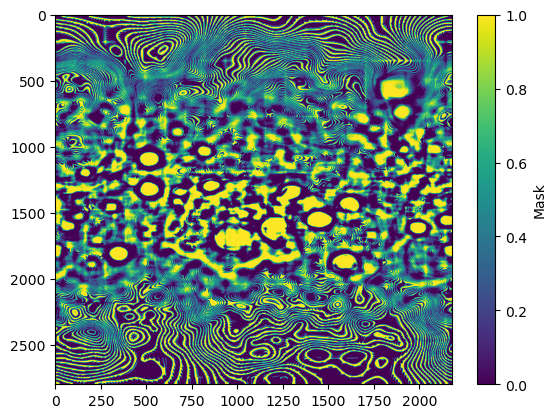

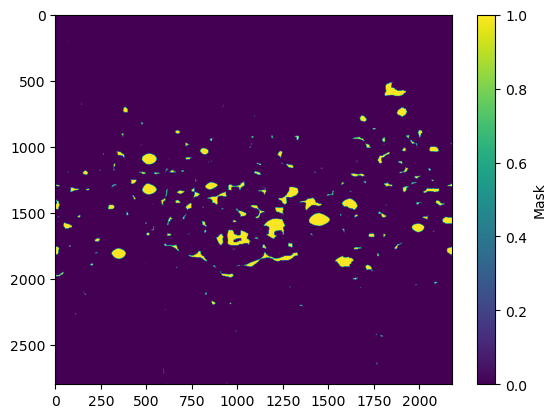

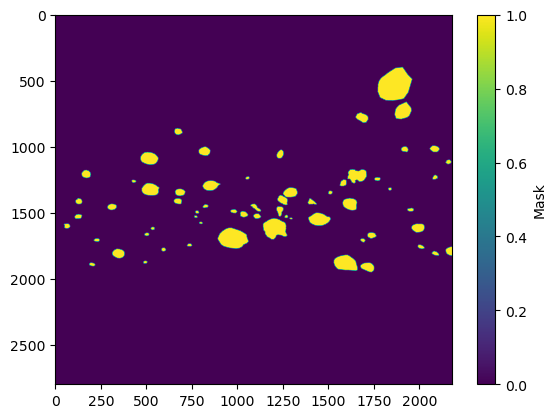

0.348


In [189]:
adaptive_thresh = cv2.adaptiveThreshold(data_clahe, 1, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    study.best_params['treshold'],  # Размер блока (должен быть нечетным)
    study.best_params['const']   # Константа вычитаемая из среднего
)
adaptive_thresh= adaptive_thresh
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study.best_params['kernel_size_close'], study.best_params['kernel_size_close']))
closed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study.best_params['kernel_size_dil'], study.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_AdTr = cv2.erode(closed, kernel2, iterations=1)

# Заливка внутренностей
#filled = closed.copy()
#contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(closed, contours, -1, 1, thickness=cv2.FILLED)

plt.imshow(adaptive_thresh, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(dilated_AdTr, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_AdTr.flatten(), 
    average='binary'  # Для бинарной сегментации
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_AdTr, '1_OpenCV_Adapt_Thresh.grd')

In [71]:
# 2. Фильтр Собеля
def objective_sobel(trial):
    # boundaries for the optimizer's
    ksize= trial.suggest_int("ksize", 3, 7, step=2) # размер ядра
    kernel_size_close = trial.suggest_int("kernel_size_close", 3, 21, step=2) # Размер ядра для создания закрытой фигуры
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 3, 21, step=2) # Размер ядра для создания дилатации
    
    sobel_x = cv2.Sobel(data_clahe, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(data_clahe, cv2.CV_64F, 0, 1, ksize=ksize)
    sobel = cv2.magnitude(sobel_x, sobel_y)
    sobel_norm = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, sobel_bin = cv2.threshold(sobel_norm, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(sobel_bin, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    final_mask = cv2.erode(closed, kernel2, iterations=1)
  
    error = jaccard_score(
        data_man.flatten(), 
        final_mask.flatten(), 
        average='binary'  # Для бинарной сегментации
    )
    print(error)
    return error

study_sob = optuna.create_study(direction='maximize')  # Максимизируем IoU
study_sob.optimize(objective_sobel, n_trials = 50)  # Количество итераций
optuna.visualization.plot_optimization_history(study_sob)
print(study_sob.best_params)

[I 2025-04-09 23:49:54,054] A new study created in memory with name: no-name-82cdd44e-2968-48a2-b591-95759a55d477
[I 2025-04-09 23:49:55,441] Trial 0 finished with value: 0.0975345076200272 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 9}. Best is trial 0 with value: 0.0975345076200272.


0.0975345076200272


[I 2025-04-09 23:49:56,838] Trial 1 finished with value: 0.11164342045853047 and parameters: {'ksize': 3, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 1 with value: 0.11164342045853047.


0.11164342045853047


[I 2025-04-09 23:49:58,216] Trial 2 finished with value: 0.12912093723714496 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 11}. Best is trial 2 with value: 0.12912093723714496.


0.12912093723714496


[I 2025-04-09 23:49:59,625] Trial 3 finished with value: 0.10376497531645788 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 3}. Best is trial 2 with value: 0.12912093723714496.


0.10376497531645788


[I 2025-04-09 23:50:01,051] Trial 4 finished with value: 0.05995064959123609 and parameters: {'ksize': 7, 'kernel_size_close': 17, 'kernel_size_dil': 17}. Best is trial 2 with value: 0.12912093723714496.


0.05995064959123609


[I 2025-04-09 23:50:02,460] Trial 5 finished with value: 0.045746511044268 and parameters: {'ksize': 3, 'kernel_size_close': 21, 'kernel_size_dil': 17}. Best is trial 2 with value: 0.12912093723714496.


0.045746511044268


[I 2025-04-09 23:50:03,869] Trial 6 finished with value: 0.04427263867538757 and parameters: {'ksize': 3, 'kernel_size_close': 21, 'kernel_size_dil': 7}. Best is trial 2 with value: 0.12912093723714496.


0.04427263867538757


[I 2025-04-09 23:50:05,274] Trial 7 finished with value: 0.18648251637165852 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 7 with value: 0.18648251637165852.


0.18648251637165852


[I 2025-04-09 23:50:06,658] Trial 8 finished with value: 0.06561934451140224 and parameters: {'ksize': 7, 'kernel_size_close': 15, 'kernel_size_dil': 19}. Best is trial 7 with value: 0.18648251637165852.


0.06561934451140224


[I 2025-04-09 23:50:08,029] Trial 9 finished with value: 0.07790011195761995 and parameters: {'ksize': 3, 'kernel_size_close': 7, 'kernel_size_dil': 11}. Best is trial 7 with value: 0.18648251637165852.


0.07790011195761995


[I 2025-04-09 23:50:09,438] Trial 10 finished with value: 0.06485138682542224 and parameters: {'ksize': 5, 'kernel_size_close': 11, 'kernel_size_dil': 15}. Best is trial 7 with value: 0.18648251637165852.


0.06485138682542224


[I 2025-04-09 23:50:10,875] Trial 11 finished with value: 0.18241658995779564 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 7 with value: 0.18648251637165852.


0.18241658995779564


[I 2025-04-09 23:50:12,298] Trial 12 finished with value: 0.18763162679353343 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.18763162679353343.


0.18763162679353343


[I 2025-04-09 23:50:13,725] Trial 13 finished with value: 0.06485138682542224 and parameters: {'ksize': 5, 'kernel_size_close': 11, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.18763162679353343.


0.06485138682542224


[I 2025-04-09 23:50:15,101] Trial 14 finished with value: 0.19796929535525126 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.19796929535525126


[I 2025-04-09 23:50:16,533] Trial 15 finished with value: 0.08270891854175877 and parameters: {'ksize': 5, 'kernel_size_close': 9, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.08270891854175877


[I 2025-04-09 23:50:17,957] Trial 16 finished with value: 0.0554167686528762 and parameters: {'ksize': 5, 'kernel_size_close': 15, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.0554167686528762


[I 2025-04-09 23:50:19,418] Trial 17 finished with value: 0.1473772983553173 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 3}. Best is trial 14 with value: 0.19796929535525126.


0.1473772983553173


[I 2025-04-09 23:50:20,895] Trial 18 finished with value: 0.06849863033341523 and parameters: {'ksize': 5, 'kernel_size_close': 9, 'kernel_size_dil': 7}. Best is trial 14 with value: 0.19796929535525126.


0.06849863033341523


[I 2025-04-09 23:50:22,335] Trial 19 finished with value: 0.08455315829557868 and parameters: {'ksize': 3, 'kernel_size_close': 7, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.08455315829557868


[I 2025-04-09 23:50:23,781] Trial 20 finished with value: 0.05891294234743003 and parameters: {'ksize': 5, 'kernel_size_close': 13, 'kernel_size_dil': 13}. Best is trial 14 with value: 0.19796929535525126.


0.05891294234743003


[I 2025-04-09 23:50:25,271] Trial 21 finished with value: 0.18763162679353343 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 14 with value: 0.19796929535525126.


0.18763162679353343


[I 2025-04-09 23:50:26,739] Trial 22 finished with value: 0.19204100837006588 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.19796929535525126.


0.19204100837006588


[I 2025-04-09 23:50:28,141] Trial 23 finished with value: 0.1317078460370672 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.19796929535525126.


0.1317078460370672


[I 2025-04-09 23:50:29,529] Trial 24 finished with value: 0.19796929535525126 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.19796929535525126


[I 2025-04-09 23:50:30,944] Trial 25 finished with value: 0.10755511911101918 and parameters: {'ksize': 5, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.10755511911101918


[I 2025-04-09 23:50:32,363] Trial 26 finished with value: 0.08055258951468415 and parameters: {'ksize': 5, 'kernel_size_close': 9, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.08055258951468415


[I 2025-04-09 23:50:33,751] Trial 27 finished with value: 0.11164342045853047 and parameters: {'ksize': 3, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.11164342045853047


[I 2025-04-09 23:50:35,142] Trial 28 finished with value: 0.19566999979781052 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.19566999979781052


[I 2025-04-09 23:50:36,540] Trial 29 finished with value: 0.1274415649655743 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.1274415649655743


[I 2025-04-09 23:50:37,981] Trial 30 finished with value: 0.13716206186508736 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.13716206186508736


[I 2025-04-09 23:50:39,439] Trial 31 finished with value: 0.19204100837006588 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.19796929535525126.


0.19204100837006588


[I 2025-04-09 23:50:40,858] Trial 32 finished with value: 0.19566999979781052 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.19566999979781052


[I 2025-04-09 23:50:42,320] Trial 33 finished with value: 0.14252836621765133 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.14252836621765133


[I 2025-04-09 23:50:43,784] Trial 34 finished with value: 0.13716206186508736 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.13716206186508736


[I 2025-04-09 23:50:45,252] Trial 35 finished with value: 0.1274415649655743 and parameters: {'ksize': 7, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.1274415649655743


[I 2025-04-09 23:50:46,664] Trial 36 finished with value: 0.19566999979781052 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.19566999979781052


[I 2025-04-09 23:50:48,084] Trial 37 finished with value: 0.10638416858132957 and parameters: {'ksize': 3, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.19796929535525126.


0.10638416858132957


[I 2025-04-09 23:50:49,534] Trial 38 finished with value: 0.05205320641697896 and parameters: {'ksize': 7, 'kernel_size_close': 19, 'kernel_size_dil': 9}. Best is trial 14 with value: 0.19796929535525126.


0.05205320641697896


[I 2025-04-09 23:50:50,942] Trial 39 finished with value: 0.13716206186508736 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.13716206186508736


[I 2025-04-09 23:50:52,343] Trial 40 finished with value: 0.15886637780791316 and parameters: {'ksize': 3, 'kernel_size_close': 3, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.15886637780791316


[I 2025-04-09 23:50:53,744] Trial 41 finished with value: 0.19566999979781052 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.19566999979781052


[I 2025-04-09 23:50:55,167] Trial 42 finished with value: 0.19204100837006588 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.19796929535525126.


0.19204100837006588


[I 2025-04-09 23:50:56,577] Trial 43 finished with value: 0.14252836621765133 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.14252836621765133


[I 2025-04-09 23:50:57,983] Trial 44 finished with value: 0.19566999979781052 and parameters: {'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.19566999979781052


[I 2025-04-09 23:50:59,420] Trial 45 finished with value: 0.1317078460370672 and parameters: {'ksize': 5, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.19796929535525126.


0.1317078460370672


[I 2025-04-09 23:51:00,851] Trial 46 finished with value: 0.10755511911101918 and parameters: {'ksize': 5, 'kernel_size_close': 7, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.10755511911101918


[I 2025-04-09 23:51:02,313] Trial 47 finished with value: 0.1960842360792457 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 14 with value: 0.19796929535525126.


0.1960842360792457


[I 2025-04-09 23:51:03,756] Trial 48 finished with value: 0.1808669141691048 and parameters: {'ksize': 7, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 14 with value: 0.19796929535525126.


0.1808669141691048


[I 2025-04-09 23:51:05,189] Trial 49 finished with value: 0.15954262355762266 and parameters: {'ksize': 7, 'kernel_size_close': 5, 'kernel_size_dil': 21}. Best is trial 14 with value: 0.19796929535525126.


0.15954262355762266
{'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 21}


{'ksize': 5, 'kernel_size_close': 3, 'kernel_size_dil': 21}


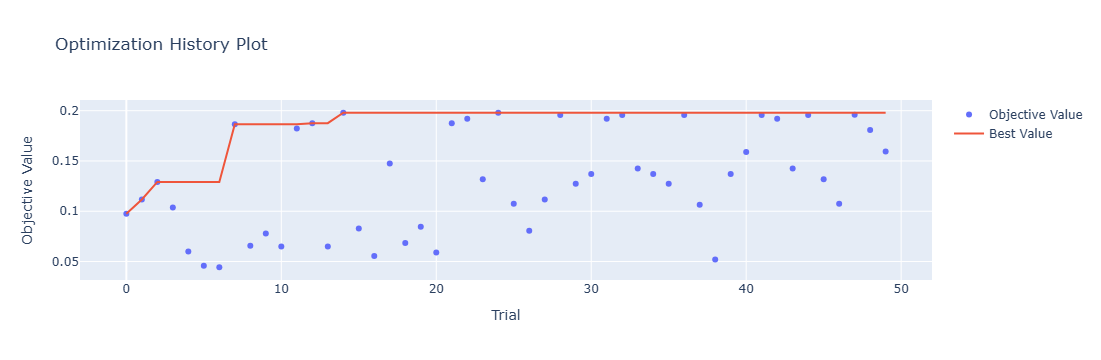

In [72]:
print(study_sob.best_params)
optuna.visualization.plot_optimization_history(study_sob)

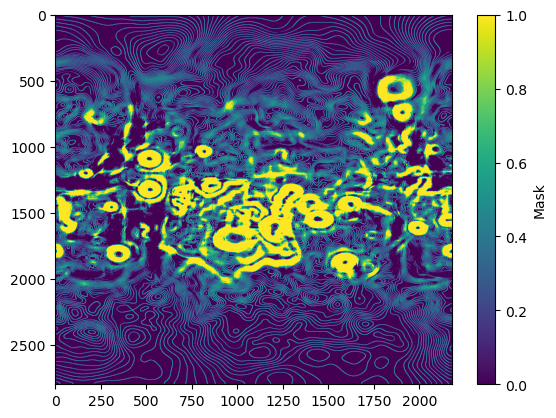

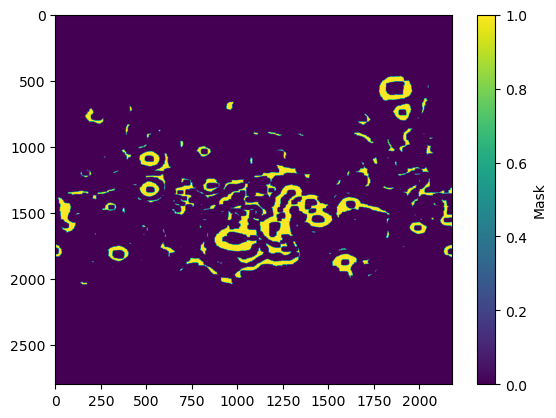

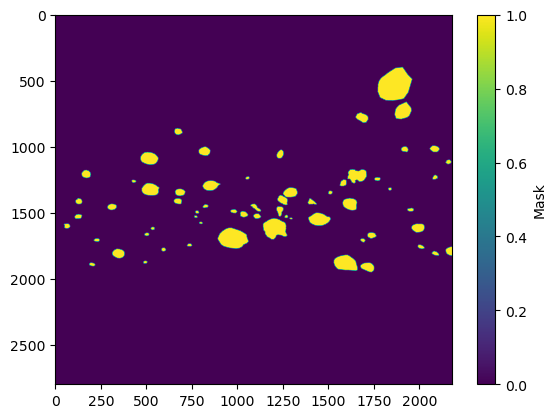

0.198


In [75]:
sobel_x = cv2.Sobel(data_clahe, cv2.CV_64F, 1, 0, ksize=study_sob.best_params['ksize'])
sobel_y = cv2.Sobel(data_clahe, cv2.CV_64F, 0, 1, ksize=study_sob.best_params['ksize'])
sobel = cv2.magnitude(sobel_x, sobel_y)
sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, sobel_bin = cv2.threshold(sobel, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study_sob.best_params['kernel_size_close'], study_sob.best_params['kernel_size_close']))
closed = cv2.morphologyEx(sobel_bin, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study_sob.best_params['kernel_size_dil'], study_sob.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_sob = cv2.erode(closed, kernel2, iterations=1)

#filled = closed.copy()
#contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(filled, contours, -1, 1, thickness=cv2.FILLED)

plt.imshow(sobel_bin, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(dilated_sob, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_sob.flatten(), 
    average='binary'  # Для бинарной сегментации
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_sob, '1_OpenCV_Sobel.grd')

In [15]:
# 3. Оператор Лапласа
def objective_laplace(trial):
    # boundaries for the optimizer's
    ksize= trial.suggest_int("ksize", 11, 31, step=2) # размер ядра
    kernel_size_close = trial.suggest_int("kernel_size_close", 3, 21, step=2) # Размер ядра для создания закрытой фигуры
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 3, 21, step=2) # Размер ядра для создания дилатации
    
    laplace = cv2.Laplacian(data_clahe, cv2.CV_64F, ksize=ksize)
    laplace = 1- cv2.normalize(laplace, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, laplace_bin = cv2.threshold(laplace, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(laplace_bin, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    final_mask = cv2.erode(closed, kernel2, iterations=1)
  
    error = jaccard_score(
        data_man.flatten(), 
        final_mask.flatten(), 
        average='binary'  # Для бинарной сегментации
    )
    print(error)
    return error

study_lap = optuna.create_study(direction='maximize')  # Максимизируем IoU
study_lap.optimize(objective_laplace, n_trials = 50)  # Количество итераций
optuna.visualization.plot_optimization_history(study_lap)

[I 2025-04-13 23:11:13,414] A new study created in memory with name: no-name-ef8d826d-4e59-4e08-b640-b50d84dcef44
[I 2025-04-13 23:11:14,817] Trial 0 finished with value: 0.03283092312175339 and parameters: {'ksize': 27, 'kernel_size_close': 15, 'kernel_size_dil': 19}. Best is trial 0 with value: 0.03283092312175339.


0.03283092312175339


[I 2025-04-13 23:11:16,168] Trial 1 finished with value: 0.03157966578923069 and parameters: {'ksize': 19, 'kernel_size_close': 9, 'kernel_size_dil': 21}. Best is trial 0 with value: 0.03283092312175339.


0.03157966578923069


[I 2025-04-13 23:11:17,563] Trial 2 finished with value: 0.032731089849638705 and parameters: {'ksize': 27, 'kernel_size_close': 21, 'kernel_size_dil': 17}. Best is trial 0 with value: 0.03283092312175339.


0.032731089849638705


[I 2025-04-13 23:11:18,948] Trial 3 finished with value: 0.03212034358878589 and parameters: {'ksize': 13, 'kernel_size_close': 19, 'kernel_size_dil': 21}. Best is trial 0 with value: 0.03283092312175339.


0.03212034358878589


[I 2025-04-13 23:11:20,350] Trial 4 finished with value: 0.03275683444610024 and parameters: {'ksize': 23, 'kernel_size_close': 15, 'kernel_size_dil': 17}. Best is trial 0 with value: 0.03283092312175339.


0.03275683444610024


[I 2025-04-13 23:11:21,789] Trial 5 finished with value: 0.033374760163187696 and parameters: {'ksize': 23, 'kernel_size_close': 11, 'kernel_size_dil': 7}. Best is trial 5 with value: 0.033374760163187696.


0.033374760163187696


[I 2025-04-13 23:11:23,220] Trial 6 finished with value: 0.03387891220123631 and parameters: {'ksize': 27, 'kernel_size_close': 15, 'kernel_size_dil': 9}. Best is trial 6 with value: 0.03387891220123631.


0.03387891220123631


[I 2025-04-13 23:11:24,655] Trial 7 finished with value: 0.049074245817475694 and parameters: {'ksize': 31, 'kernel_size_close': 7, 'kernel_size_dil': 7}. Best is trial 7 with value: 0.049074245817475694.


0.049074245817475694


[I 2025-04-13 23:11:26,113] Trial 8 finished with value: 0.1098089573477463 and parameters: {'ksize': 21, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 8 with value: 0.1098089573477463.


0.1098089573477463


[I 2025-04-13 23:11:27,517] Trial 9 finished with value: 0.03225653280152202 and parameters: {'ksize': 19, 'kernel_size_close': 13, 'kernel_size_dil': 19}. Best is trial 8 with value: 0.1098089573477463.


0.03225653280152202


[I 2025-04-13 23:11:28,948] Trial 10 finished with value: 0.09586145285276583 and parameters: {'ksize': 11, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 8 with value: 0.1098089573477463.


0.09586145285276583


[I 2025-04-13 23:11:30,356] Trial 11 finished with value: 0.11553074561668493 and parameters: {'ksize': 13, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 11 with value: 0.11553074561668493.


0.11553074561668493


[I 2025-04-13 23:11:31,784] Trial 12 finished with value: 0.12883995735180637 and parameters: {'ksize': 15, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 12 with value: 0.12883995735180637.


0.12883995735180637


[I 2025-04-13 23:11:33,218] Trial 13 finished with value: 0.061429916224321084 and parameters: {'ksize': 15, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 12 with value: 0.12883995735180637.


0.061429916224321084


[I 2025-04-13 23:11:34,619] Trial 14 finished with value: 0.033324649820652065 and parameters: {'ksize': 15, 'kernel_size_close': 7, 'kernel_size_dil': 3}. Best is trial 12 with value: 0.12883995735180637.


0.033324649820652065


[I 2025-04-13 23:11:36,025] Trial 15 finished with value: 0.09586145285276583 and parameters: {'ksize': 11, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 12 with value: 0.12883995735180637.


0.09586145285276583


[I 2025-04-13 23:11:37,411] Trial 16 finished with value: 0.03469106145337868 and parameters: {'ksize': 15, 'kernel_size_close': 7, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.12883995735180637.


0.03469106145337868


[I 2025-04-13 23:11:38,827] Trial 17 finished with value: 0.0611676881249712 and parameters: {'ksize': 17, 'kernel_size_close': 5, 'kernel_size_dil': 11}. Best is trial 12 with value: 0.12883995735180637.


0.0611676881249712


[I 2025-04-13 23:11:40,190] Trial 18 finished with value: 0.032214518594839286 and parameters: {'ksize': 13, 'kernel_size_close': 9, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.12883995735180637.


0.032214518594839286


[I 2025-04-13 23:11:41,610] Trial 19 finished with value: 0.0418082508770855 and parameters: {'ksize': 17, 'kernel_size_close': 5, 'kernel_size_dil': 3}. Best is trial 12 with value: 0.12883995735180637.


0.0418082508770855


[I 2025-04-13 23:11:42,951] Trial 20 finished with value: 0.03235262042788095 and parameters: {'ksize': 11, 'kernel_size_close': 11, 'kernel_size_dil': 11}. Best is trial 12 with value: 0.12883995735180637.


0.03235262042788095


[I 2025-04-13 23:11:44,375] Trial 21 finished with value: 0.10768394046857481 and parameters: {'ksize': 23, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 12 with value: 0.12883995735180637.


0.10768394046857481


[I 2025-04-13 23:11:45,801] Trial 22 finished with value: 0.11128977137223374 and parameters: {'ksize': 19, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 12 with value: 0.12883995735180637.


0.11128977137223374


[I 2025-04-13 23:11:47,199] Trial 23 finished with value: 0.05142674460981918 and parameters: {'ksize': 17, 'kernel_size_close': 5, 'kernel_size_dil': 7}. Best is trial 12 with value: 0.12883995735180637.


0.05142674460981918


[I 2025-04-13 23:11:48,592] Trial 24 finished with value: 0.12600726780619367 and parameters: {'ksize': 13, 'kernel_size_close': 3, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.12883995735180637.


0.12600726780619367


[I 2025-04-13 23:11:49,953] Trial 25 finished with value: 0.03329543059411413 and parameters: {'ksize': 13, 'kernel_size_close': 7, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.12883995735180637.


0.03329543059411413


[I 2025-04-13 23:11:51,343] Trial 26 finished with value: 0.061283072238019196 and parameters: {'ksize': 13, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.12883995735180637.


0.061283072238019196


[I 2025-04-13 23:11:52,688] Trial 27 finished with value: 0.03229179115993016 and parameters: {'ksize': 15, 'kernel_size_close': 9, 'kernel_size_dil': 15}. Best is trial 12 with value: 0.12883995735180637.


0.03229179115993016


[I 2025-04-13 23:11:54,110] Trial 28 finished with value: 0.0870216986178591 and parameters: {'ksize': 11, 'kernel_size_close': 3, 'kernel_size_dil': 11}. Best is trial 12 with value: 0.12883995735180637.


0.0870216986178591


[I 2025-04-13 23:11:55,487] Trial 29 finished with value: 0.03219609931365966 and parameters: {'ksize': 13, 'kernel_size_close': 19, 'kernel_size_dil': 19}. Best is trial 12 with value: 0.12883995735180637.


0.03219609931365966


[I 2025-04-13 23:11:56,865] Trial 30 finished with value: 0.06603471626823156 and parameters: {'ksize': 17, 'kernel_size_close': 5, 'kernel_size_dil': 13}. Best is trial 12 with value: 0.12883995735180637.


0.06603471626823156


[I 2025-04-13 23:11:58,272] Trial 31 finished with value: 0.13014581367191871 and parameters: {'ksize': 19, 'kernel_size_close': 3, 'kernel_size_dil': 11}. Best is trial 31 with value: 0.13014581367191871.


0.13014581367191871


[I 2025-04-13 23:11:59,668] Trial 32 finished with value: 0.1287647094861295 and parameters: {'ksize': 21, 'kernel_size_close': 3, 'kernel_size_dil': 11}. Best is trial 31 with value: 0.13014581367191871.


0.1287647094861295


[I 2025-04-13 23:12:01,066] Trial 33 finished with value: 0.04187692337958681 and parameters: {'ksize': 21, 'kernel_size_close': 7, 'kernel_size_dil': 11}. Best is trial 31 with value: 0.13014581367191871.


0.04187692337958681


[I 2025-04-13 23:12:02,490] Trial 34 finished with value: 0.08049793433355078 and parameters: {'ksize': 25, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 31 with value: 0.13014581367191871.


0.08049793433355078


[I 2025-04-13 23:12:03,886] Trial 35 finished with value: 0.18003050754774 and parameters: {'ksize': 19, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 35 with value: 0.18003050754774.


0.18003050754774


[I 2025-04-13 23:12:05,271] Trial 36 finished with value: 0.03191945400390783 and parameters: {'ksize': 21, 'kernel_size_close': 17, 'kernel_size_dil': 21}. Best is trial 35 with value: 0.18003050754774.


0.03191945400390783


[I 2025-04-13 23:12:06,731] Trial 37 finished with value: 0.04774501017132981 and parameters: {'ksize': 19, 'kernel_size_close': 5, 'kernel_size_dil': 5}. Best is trial 35 with value: 0.18003050754774.


0.04774501017132981


[I 2025-04-13 23:12:08,101] Trial 38 finished with value: 0.034364841187111965 and parameters: {'ksize': 25, 'kernel_size_close': 9, 'kernel_size_dil': 17}. Best is trial 35 with value: 0.18003050754774.


0.034364841187111965


[I 2025-04-13 23:12:09,460] Trial 39 finished with value: 0.03308892428178681 and parameters: {'ksize': 19, 'kernel_size_close': 13, 'kernel_size_dil': 9}. Best is trial 35 with value: 0.18003050754774.


0.03308892428178681


[I 2025-04-13 23:12:10,849] Trial 40 finished with value: 0.1287647094861295 and parameters: {'ksize': 21, 'kernel_size_close': 3, 'kernel_size_dil': 11}. Best is trial 35 with value: 0.18003050754774.


0.1287647094861295


[I 2025-04-13 23:12:12,218] Trial 41 finished with value: 0.1287647094861295 and parameters: {'ksize': 21, 'kernel_size_close': 3, 'kernel_size_dil': 11}. Best is trial 35 with value: 0.18003050754774.


0.1287647094861295


[I 2025-04-13 23:12:13,618] Trial 42 finished with value: 0.10768394046857481 and parameters: {'ksize': 23, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 35 with value: 0.18003050754774.


0.10768394046857481


[I 2025-04-13 23:12:15,001] Trial 43 finished with value: 0.05530335031065752 and parameters: {'ksize': 23, 'kernel_size_close': 5, 'kernel_size_dil': 7}. Best is trial 35 with value: 0.18003050754774.


0.05530335031065752


[I 2025-04-13 23:12:16,382] Trial 44 finished with value: 0.04187692337958681 and parameters: {'ksize': 21, 'kernel_size_close': 7, 'kernel_size_dil': 11}. Best is trial 35 with value: 0.18003050754774.


0.04187692337958681


[I 2025-04-13 23:12:17,759] Trial 45 finished with value: 0.1411812963173856 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 35 with value: 0.18003050754774.


0.1411812963173856


[I 2025-04-13 23:12:19,140] Trial 46 finished with value: 0.033324529393480413 and parameters: {'ksize': 29, 'kernel_size_close': 21, 'kernel_size_dil': 13}. Best is trial 35 with value: 0.18003050754774.


0.033324529393480413


[I 2025-04-13 23:12:20,502] Trial 47 finished with value: 0.17638580256534717 and parameters: {'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 17}. Best is trial 35 with value: 0.18003050754774.


0.17638580256534717


[I 2025-04-13 23:12:21,924] Trial 48 finished with value: 0.08643442812917013 and parameters: {'ksize': 25, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 35 with value: 0.18003050754774.


0.08643442812917013


[I 2025-04-13 23:12:23,291] Trial 49 finished with value: 0.20743889801400783 and parameters: {'ksize': 27, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 49 with value: 0.20743889801400783.


0.20743889801400783


{'ksize': 25, 'kernel_size_close': 3, 'kernel_size_dil': 21}


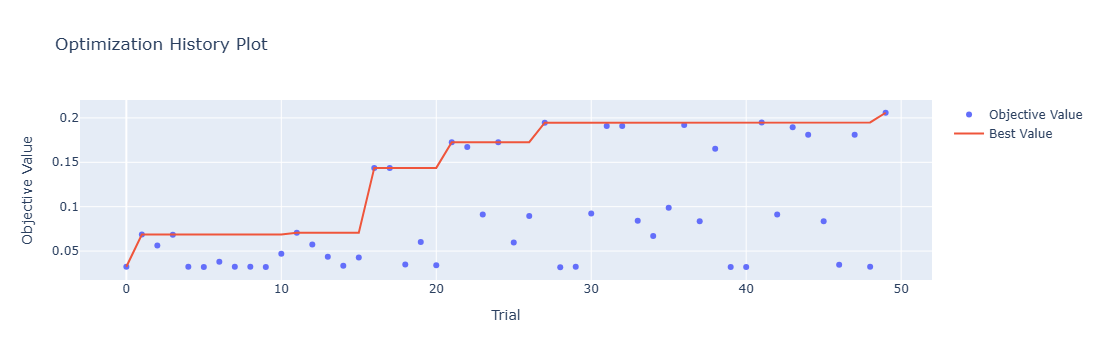

In [104]:
print(study_lap.best_params)
optuna.visualization.plot_optimization_history(study_lap)

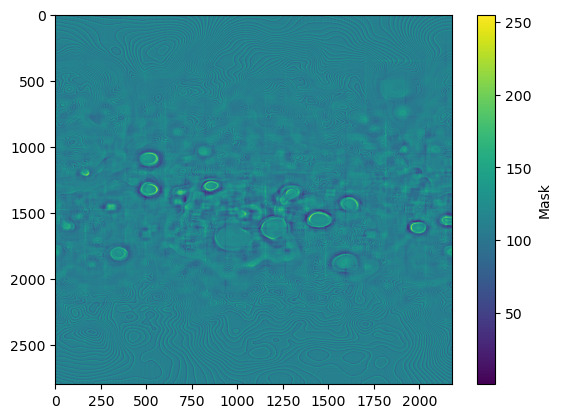

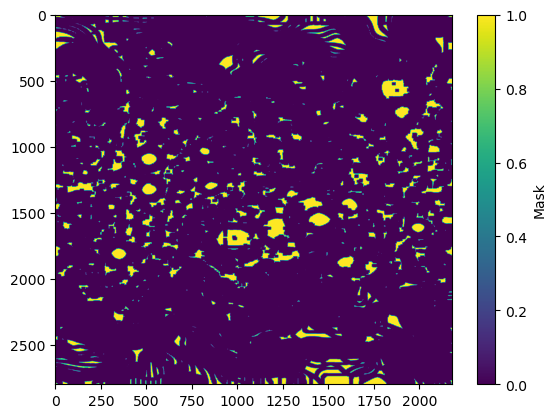

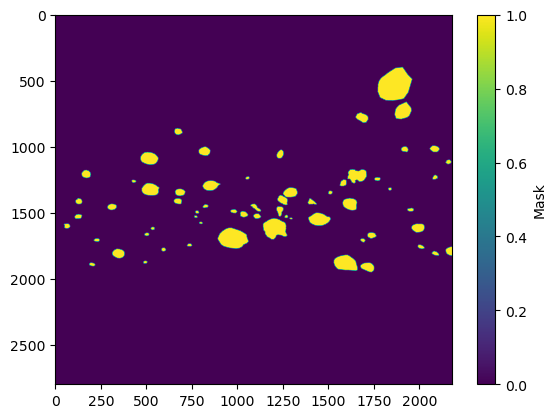

0.207


In [17]:
# 3. Оператор Лапласа
laplace = cv2.Laplacian(data_clahe, cv2.CV_64F, ksize=study_lap.best_params['ksize'])

laplace = 1-cv2.normalize(laplace, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, laplace_bin = cv2.threshold(laplace, 0, 1, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study_lap.best_params['kernel_size_close'], study_lap.best_params['kernel_size_close']))
closed = cv2.morphologyEx(laplace_bin, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study_lap.best_params['kernel_size_dil'], study_lap.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_lap = cv2.erode(closed, kernel2, iterations=1)

#filled = closed.copy()
#contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(filled, contours, -1, 1, thickness=cv2.FILLED)

plt.imshow(laplace, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(dilated_lap, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_lap.flatten(), 
    average='binary'  # Для бинарной сегментации
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_lap, '1_OpenCV_Laplace.grd')

In [167]:
# 4. Детектор Канни
def objective_canny(trial):
    # boundaries for the optimizer's
    threshold1 = trial.suggest_int("tr1", 0, 5, step=1) # порог 1
    threshold2 = trial.suggest_int("tr2", 11, 51, step=2) # порог 2
    kernel_size_close = trial.suggest_int("kernel_size_close", 3, 31, step=2) # Размер ядра для создания закрытой фигуры
    kernel_size_dil = trial.suggest_int("kernel_size_dil", 3, 31, step=2) # Размер ядра для создания дилатации
    
    canny = cv2.Canny(data_clahe, threshold1 =  threshold1, threshold2 = threshold2)
    canny = cv2.normalize(canny, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, canny_bin = cv2.threshold(canny, 0, 1, cv2.THRESH_BINARY)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size_close, kernel_size_close))
    closed = cv2.morphologyEx(canny_bin, cv2.MORPH_CLOSE, kernel)
    kernel2 = np.ones((kernel_size_dil, kernel_size_dil), dtype=np.uint8)
    final_mask = cv2.erode(closed, kernel2, iterations=1)
  
    error = jaccard_score(
        data_man.flatten(), 
        final_mask.flatten(), 
        average='binary'  # Для бинарной сегментации
    )
    print(error)
    return error

study_canny = optuna.create_study(direction='maximize')  # Максимизируем IoU
study_canny.optimize(objective_canny, n_trials = 50)  # Количество итераций

[I 2025-04-10 01:00:23,845] A new study created in memory with name: no-name-3a517137-3d54-4673-b7fd-31c2d740ae24
[I 2025-04-10 01:00:25,206] Trial 0 finished with value: 0.011199492937073046 and parameters: {'tr1': 1, 'tr2': 49, 'kernel_size_close': 9, 'kernel_size_dil': 3}. Best is trial 0 with value: 0.011199492937073046.


0.011199492937073046


[I 2025-04-10 01:00:26,550] Trial 1 finished with value: 0.04131043713173437 and parameters: {'tr1': 2, 'tr2': 17, 'kernel_size_close': 23, 'kernel_size_dil': 11}. Best is trial 1 with value: 0.04131043713173437.


0.04131043713173437


[I 2025-04-10 01:00:27,926] Trial 2 finished with value: 0.032602559732198666 and parameters: {'tr1': 2, 'tr2': 23, 'kernel_size_close': 27, 'kernel_size_dil': 9}. Best is trial 1 with value: 0.04131043713173437.


0.032602559732198666


[I 2025-04-10 01:00:29,250] Trial 3 finished with value: 0.0 and parameters: {'tr1': 3, 'tr2': 21, 'kernel_size_close': 3, 'kernel_size_dil': 31}. Best is trial 1 with value: 0.04131043713173437.


0.0


[I 2025-04-10 01:00:30,669] Trial 4 finished with value: 0.039536147248514016 and parameters: {'tr1': 1, 'tr2': 11, 'kernel_size_close': 31, 'kernel_size_dil': 25}. Best is trial 1 with value: 0.04131043713173437.


0.039536147248514016


[I 2025-04-10 01:00:32,017] Trial 5 finished with value: 0.0 and parameters: {'tr1': 0, 'tr2': 41, 'kernel_size_close': 3, 'kernel_size_dil': 19}. Best is trial 1 with value: 0.04131043713173437.


0.0


[I 2025-04-10 01:00:33,330] Trial 6 finished with value: 0.06215396033973987 and parameters: {'tr1': 1, 'tr2': 11, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 6 with value: 0.06215396033973987.


0.06215396033973987


[I 2025-04-10 01:00:34,678] Trial 7 finished with value: 0.016348386403909145 and parameters: {'tr1': 5, 'tr2': 41, 'kernel_size_close': 21, 'kernel_size_dil': 5}. Best is trial 6 with value: 0.06215396033973987.


0.016348386403909145


[I 2025-04-10 01:00:36,041] Trial 8 finished with value: 0.026944752628740215 and parameters: {'tr1': 1, 'tr2': 25, 'kernel_size_close': 31, 'kernel_size_dil': 11}. Best is trial 6 with value: 0.06215396033973987.


0.026944752628740215


[I 2025-04-10 01:00:37,361] Trial 9 finished with value: 0.04592448234566388 and parameters: {'tr1': 1, 'tr2': 13, 'kernel_size_close': 19, 'kernel_size_dil': 13}. Best is trial 6 with value: 0.06215396033973987.


0.04592448234566388


[I 2025-04-10 01:00:38,743] Trial 10 finished with value: 0.01933151553333071 and parameters: {'tr1': 4, 'tr2': 33, 'kernel_size_close': 13, 'kernel_size_dil': 19}. Best is trial 6 with value: 0.06215396033973987.


0.01933151553333071


[I 2025-04-10 01:00:40,121] Trial 11 finished with value: 0.053080615529394005 and parameters: {'tr1': 0, 'tr2': 11, 'kernel_size_close': 15, 'kernel_size_dil': 15}. Best is trial 6 with value: 0.06215396033973987.


0.053080615529394005


[I 2025-04-10 01:00:41,482] Trial 12 finished with value: 0.06419473415938257 and parameters: {'tr1': 0, 'tr2': 11, 'kernel_size_close': 11, 'kernel_size_dil': 17}. Best is trial 12 with value: 0.06419473415938257.


0.06419473415938257


[I 2025-04-10 01:00:42,851] Trial 13 finished with value: 0.03203801385822339 and parameters: {'tr1': 0, 'tr2': 27, 'kernel_size_close': 9, 'kernel_size_dil': 21}. Best is trial 12 with value: 0.06419473415938257.


0.03203801385822339


[I 2025-04-10 01:00:44,226] Trial 14 finished with value: 0.06649426323282188 and parameters: {'tr1': 3, 'tr2': 17, 'kernel_size_close': 9, 'kernel_size_dil': 25}. Best is trial 14 with value: 0.06649426323282188.


0.06649426323282188


[I 2025-04-10 01:00:45,583] Trial 15 finished with value: 0.060382296428808054 and parameters: {'tr1': 3, 'tr2': 17, 'kernel_size_close': 11, 'kernel_size_dil': 25}. Best is trial 14 with value: 0.06649426323282188.


0.060382296428808054


[I 2025-04-10 01:00:46,926] Trial 16 finished with value: 0.026157618497578375 and parameters: {'tr1': 4, 'tr2': 31, 'kernel_size_close': 7, 'kernel_size_dil': 31}. Best is trial 14 with value: 0.06649426323282188.


0.026157618497578375


[I 2025-04-10 01:00:48,252] Trial 17 finished with value: 0.049178904832549886 and parameters: {'tr1': 4, 'tr2': 17, 'kernel_size_close': 15, 'kernel_size_dil': 25}. Best is trial 14 with value: 0.06649426323282188.


0.049178904832549886


[I 2025-04-10 01:00:49,599] Trial 18 finished with value: 0.042430594658114426 and parameters: {'tr1': 3, 'tr2': 19, 'kernel_size_close': 17, 'kernel_size_dil': 23}. Best is trial 14 with value: 0.06649426323282188.


0.042430594658114426


[I 2025-04-10 01:00:50,942] Trial 19 finished with value: 0.024566223697979606 and parameters: {'tr1': 2, 'tr2': 29, 'kernel_size_close': 11, 'kernel_size_dil': 29}. Best is trial 14 with value: 0.06649426323282188.


0.024566223697979606


[I 2025-04-10 01:00:52,314] Trial 20 finished with value: 0.016222076189651713 and parameters: {'tr1': 5, 'tr2': 35, 'kernel_size_close': 7, 'kernel_size_dil': 27}. Best is trial 14 with value: 0.06649426323282188.


0.016222076189651713


[I 2025-04-10 01:00:53,646] Trial 21 finished with value: 0.05868164669886564 and parameters: {'tr1': 0, 'tr2': 13, 'kernel_size_close': 5, 'kernel_size_dil': 17}. Best is trial 14 with value: 0.06649426323282188.


0.05868164669886564


[I 2025-04-10 01:00:54,993] Trial 22 finished with value: 0.07527223462343317 and parameters: {'tr1': 1, 'tr2': 15, 'kernel_size_close': 7, 'kernel_size_dil': 15}. Best is trial 22 with value: 0.07527223462343317.


0.07527223462343317


[I 2025-04-10 01:00:56,324] Trial 23 finished with value: 0.061236610072186934 and parameters: {'tr1': 2, 'tr2': 15, 'kernel_size_close': 11, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.07527223462343317.


0.061236610072186934


[I 2025-04-10 01:00:57,647] Trial 24 finished with value: 0.05542995286315262 and parameters: {'tr1': 0, 'tr2': 21, 'kernel_size_close': 7, 'kernel_size_dil': 17}. Best is trial 22 with value: 0.07527223462343317.


0.05542995286315262


[I 2025-04-10 01:00:58,975] Trial 25 finished with value: 0.051003039791452716 and parameters: {'tr1': 3, 'tr2': 15, 'kernel_size_close': 13, 'kernel_size_dil': 7}. Best is trial 22 with value: 0.07527223462343317.


0.051003039791452716


[I 2025-04-10 01:01:00,306] Trial 26 finished with value: 0.04805240759336298 and parameters: {'tr1': 1, 'tr2': 23, 'kernel_size_close': 9, 'kernel_size_dil': 13}. Best is trial 22 with value: 0.07527223462343317.


0.04805240759336298


[I 2025-04-10 01:01:01,631] Trial 27 finished with value: 0.048835955515283816 and parameters: {'tr1': 2, 'tr2': 19, 'kernel_size_close': 13, 'kernel_size_dil': 21}. Best is trial 22 with value: 0.07527223462343317.


0.048835955515283816


[I 2025-04-10 01:01:02,950] Trial 28 finished with value: 0.06313728652581402 and parameters: {'tr1': 0, 'tr2': 15, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 22 with value: 0.07527223462343317.


0.06313728652581402


[I 2025-04-10 01:01:04,283] Trial 29 finished with value: 0.003266192924807419 and parameters: {'tr1': 1, 'tr2': 47, 'kernel_size_close': 9, 'kernel_size_dil': 19}. Best is trial 22 with value: 0.07527223462343317.


0.003266192924807419


[I 2025-04-10 01:01:05,653] Trial 30 finished with value: 0.034117115290044395 and parameters: {'tr1': 4, 'tr2': 25, 'kernel_size_close': 17, 'kernel_size_dil': 3}. Best is trial 22 with value: 0.07527223462343317.


0.034117115290044395


[I 2025-04-10 01:01:07,043] Trial 31 finished with value: 0.06313728652581402 and parameters: {'tr1': 0, 'tr2': 15, 'kernel_size_close': 5, 'kernel_size_dil': 15}. Best is trial 22 with value: 0.07527223462343317.


0.06313728652581402


[I 2025-04-10 01:01:08,400] Trial 32 finished with value: 0.06574646232624054 and parameters: {'tr1': 0, 'tr2': 19, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 22 with value: 0.07527223462343317.


0.06574646232624054


[I 2025-04-10 01:01:09,749] Trial 33 finished with value: 0.06615504309181164 and parameters: {'tr1': 1, 'tr2': 19, 'kernel_size_close': 7, 'kernel_size_dil': 11}. Best is trial 22 with value: 0.07527223462343317.


0.06615504309181164


[I 2025-04-10 01:01:11,085] Trial 34 finished with value: 0.010342393538126129 and parameters: {'tr1': 2, 'tr2': 21, 'kernel_size_close': 3, 'kernel_size_dil': 9}. Best is trial 22 with value: 0.07527223462343317.


0.010342393538126129


[I 2025-04-10 01:01:12,435] Trial 35 finished with value: 0.055132685870191225 and parameters: {'tr1': 2, 'tr2': 23, 'kernel_size_close': 7, 'kernel_size_dil': 11}. Best is trial 22 with value: 0.07527223462343317.


0.055132685870191225


[I 2025-04-10 01:01:13,795] Trial 36 finished with value: 0.03815490256522895 and parameters: {'tr1': 1, 'tr2': 19, 'kernel_size_close': 25, 'kernel_size_dil': 9}. Best is trial 22 with value: 0.07527223462343317.


0.03815490256522895


[I 2025-04-10 01:01:15,141] Trial 37 finished with value: 0.0036535101690170755 and parameters: {'tr1': 3, 'tr2': 19, 'kernel_size_close': 3, 'kernel_size_dil': 13}. Best is trial 22 with value: 0.07527223462343317.


0.0036535101690170755


[I 2025-04-10 01:01:16,484] Trial 38 finished with value: 0.039414322127925006 and parameters: {'tr1': 1, 'tr2': 27, 'kernel_size_close': 9, 'kernel_size_dil': 7}. Best is trial 22 with value: 0.07527223462343317.


0.039414322127925006


[I 2025-04-10 01:01:17,814] Trial 39 finished with value: 0.0048120055460402905 and parameters: {'tr1': 1, 'tr2': 51, 'kernel_size_close': 5, 'kernel_size_dil': 11}. Best is trial 22 with value: 0.07527223462343317.


0.0048120055460402905


[I 2025-04-10 01:01:19,191] Trial 40 finished with value: 0.07312344521424778 and parameters: {'tr1': 2, 'tr2': 17, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 22 with value: 0.07527223462343317.


0.07312344521424778


[I 2025-04-10 01:01:20,556] Trial 41 finished with value: 0.07596978260796974 and parameters: {'tr1': 2, 'tr2': 13, 'kernel_size_close': 7, 'kernel_size_dil': 13}. Best is trial 41 with value: 0.07596978260796974.


0.07596978260796974


[I 2025-04-10 01:01:21,877] Trial 42 finished with value: 0.018232009973594754 and parameters: {'tr1': 2, 'tr2': 13, 'kernel_size_close': 3, 'kernel_size_dil': 7}. Best is trial 41 with value: 0.07596978260796974.


0.018232009973594754


[I 2025-04-10 01:01:23,234] Trial 43 finished with value: 0.06680712174439635 and parameters: {'tr1': 2, 'tr2': 13, 'kernel_size_close': 9, 'kernel_size_dil': 13}. Best is trial 41 with value: 0.07596978260796974.


0.06680712174439635


[I 2025-04-10 01:01:24,576] Trial 44 finished with value: 0.06781646485207588 and parameters: {'tr1': 2, 'tr2': 13, 'kernel_size_close': 9, 'kernel_size_dil': 15}. Best is trial 41 with value: 0.07596978260796974.


0.06781646485207588


[I 2025-04-10 01:01:25,942] Trial 45 finished with value: 0.06296609432739543 and parameters: {'tr1': 2, 'tr2': 11, 'kernel_size_close': 11, 'kernel_size_dil': 15}. Best is trial 41 with value: 0.07596978260796974.


0.06296609432739543


[I 2025-04-10 01:01:27,297] Trial 46 finished with value: 0.05512412273283277 and parameters: {'tr1': 2, 'tr2': 13, 'kernel_size_close': 13, 'kernel_size_dil': 13}. Best is trial 41 with value: 0.07596978260796974.


0.05512412273283277


[I 2025-04-10 01:01:28,678] Trial 47 finished with value: 0.0383317508164658 and parameters: {'tr1': 2, 'tr2': 13, 'kernel_size_close': 29, 'kernel_size_dil': 9}. Best is trial 41 with value: 0.07596978260796974.


0.0383317508164658


[I 2025-04-10 01:01:30,058] Trial 48 finished with value: 0.04560591795561533 and parameters: {'tr1': 3, 'tr2': 11, 'kernel_size_close': 21, 'kernel_size_dil': 17}. Best is trial 41 with value: 0.07596978260796974.


0.04560591795561533


[I 2025-04-10 01:01:31,421] Trial 49 finished with value: 0.04913832413135325 and parameters: {'tr1': 2, 'tr2': 17, 'kernel_size_close': 15, 'kernel_size_dil': 19}. Best is trial 41 with value: 0.07596978260796974.


0.04913832413135325


{'tr1': 2, 'tr2': 13, 'kernel_size_close': 7, 'kernel_size_dil': 13}


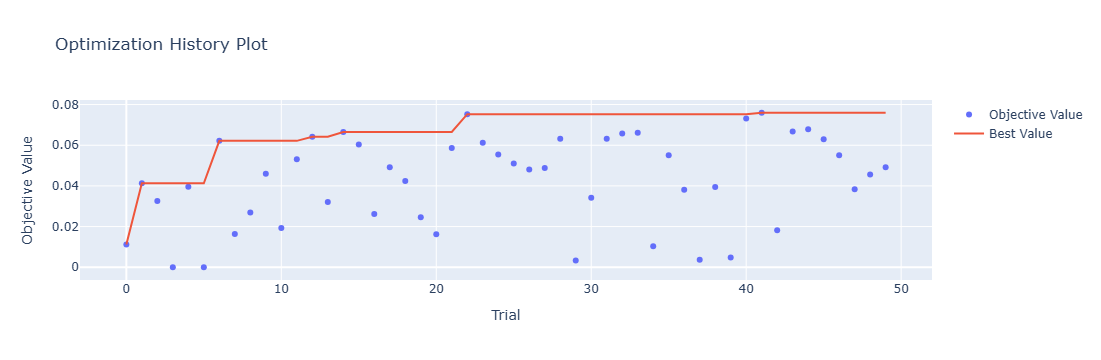

In [169]:
print(study_canny.best_params)
optuna.visualization.plot_optimization_history(study_canny)

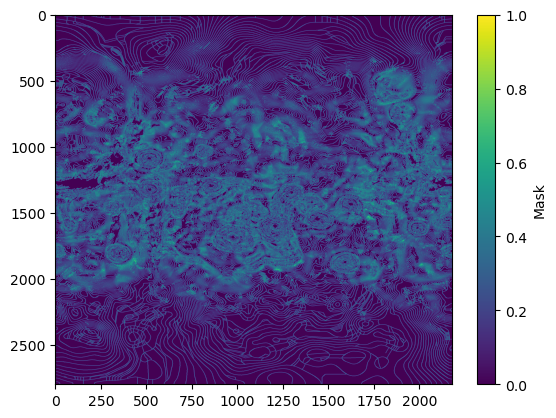

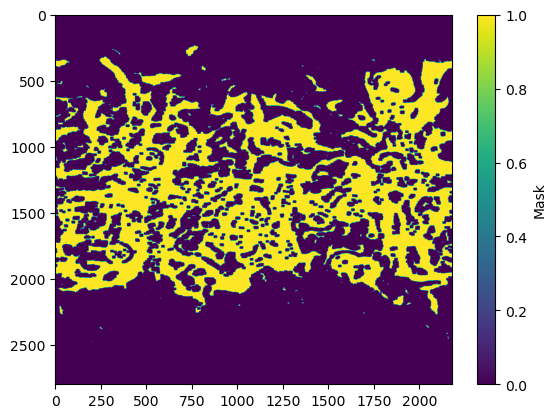

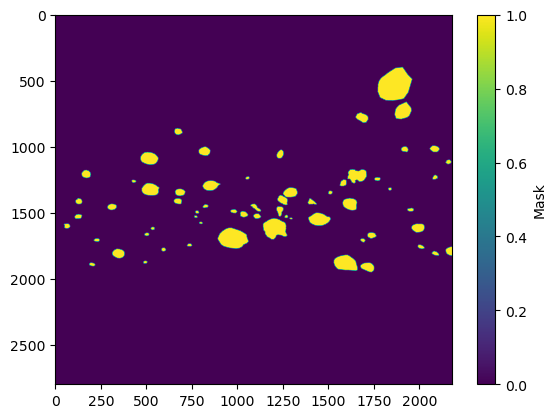

0.076


In [171]:
canny = cv2.Canny(data_clahe, threshold1 = study_canny.best_params['tr1'], threshold2 = study_canny.best_params['tr2'])
#canny = cv2.Canny(data_clahe, threshold1 = 0, threshold2 = 50)
canny = cv2.normalize(canny, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
_, canny_bin = cv2.threshold(canny, 0, 1, cv2.THRESH_BINARY)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (study_canny.best_params['kernel_size_close'], study_canny.best_params['kernel_size_close']))
closed = cv2.morphologyEx(canny_bin, cv2.MORPH_CLOSE, kernel)
kernel2 = np.ones((study_canny.best_params['kernel_size_dil'], study_canny.best_params['kernel_size_dil']), dtype=np.uint8)
dilated_canny = cv2.erode(closed, kernel2, iterations=1)

plt.imshow(canny_bin, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(dilated_canny, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    dilated_canny.flatten(), 
    average='binary'  # Для бинарной сегментации
    )
print(round(error, 3))

write_ascii_grid(Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, dilated_canny, '1_OpenCV_Canny.grd')

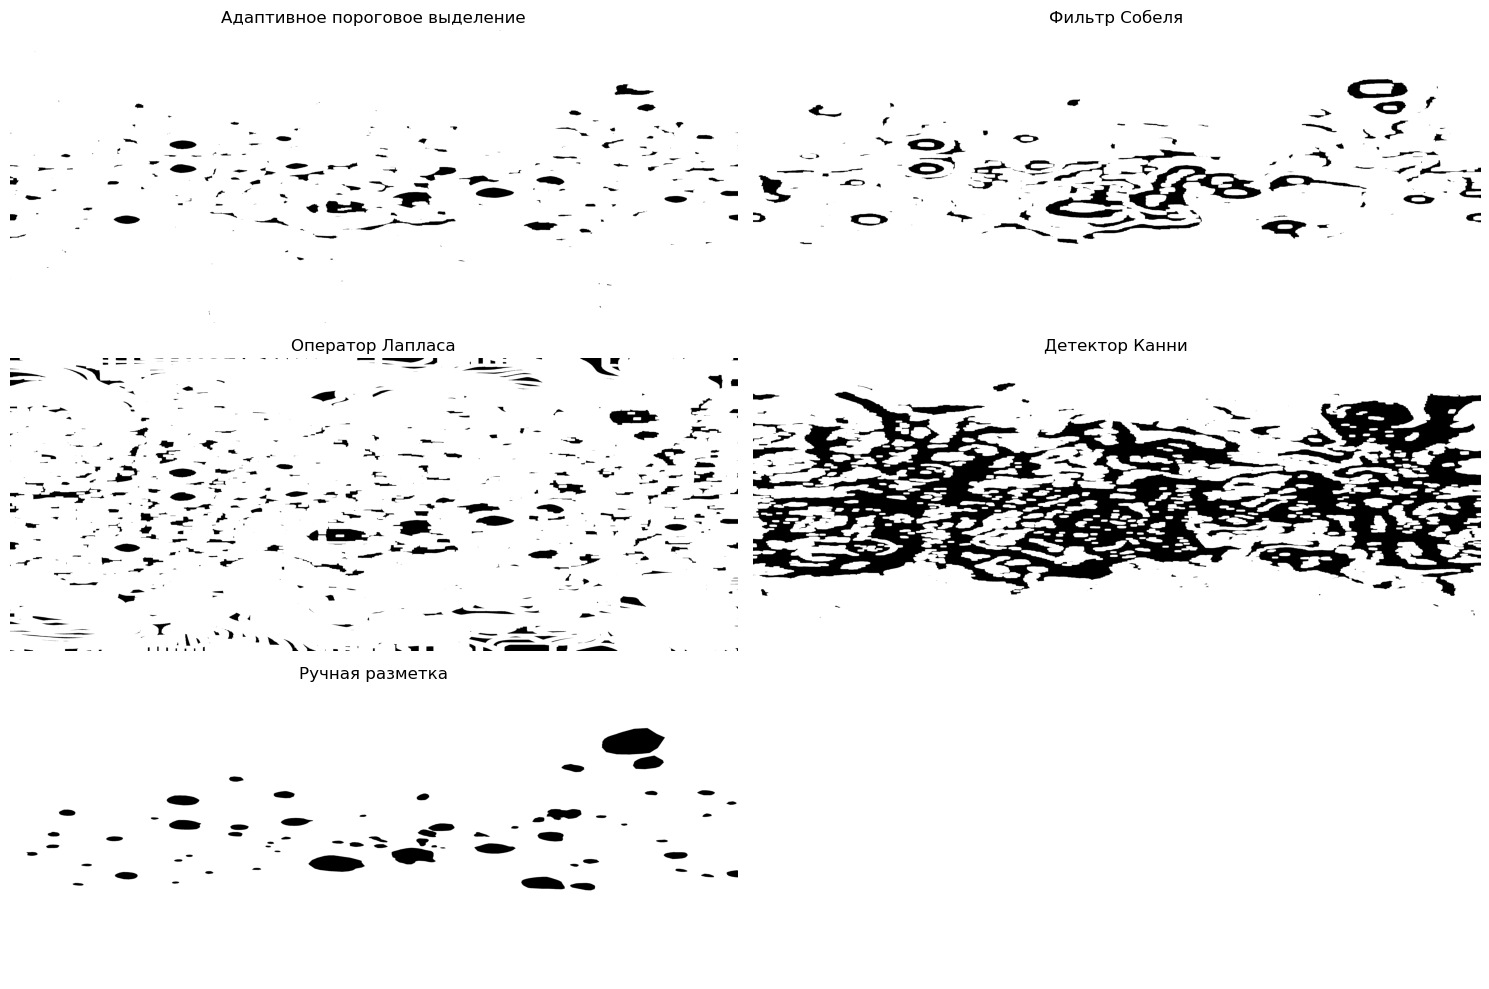

In [190]:
# Визуализация результатов
plt.figure(figsize=(15, 10))

plt.subplot(3, 2, 1)
plt.imshow(1-dilated_AdTr, cmap='gray', aspect='auto')
plt.title('Адаптивное пороговое выделение')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(1-dilated_sob, cmap='gray', aspect='auto')
plt.title('Фильтр Собеля')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(1-dilated_lap, cmap='gray', aspect='auto')
plt.title('Оператор Лапласа')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(1-dilated_canny, cmap='gray', aspect='auto')
plt.title('Детектор Канни')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(1-data_man, cmap='gray', aspect='auto')
plt.title('Ручная разметка')
plt.axis('off')

plt.tight_layout()
plt.show()

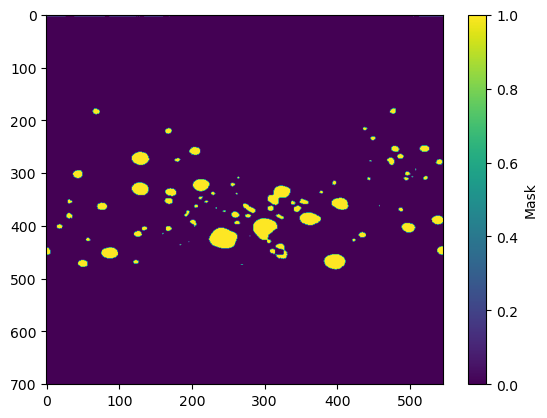

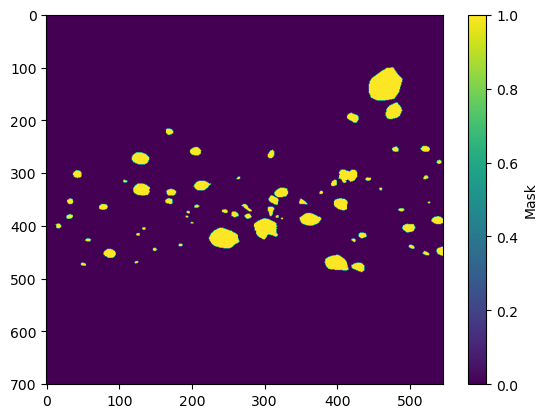

0.466


In [55]:
file_manual_path = 'Manual_mask_big_dx20km.grd'
params = read_surfer6_grd(file_manual_path)

Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data_man = params
data_man[data_man == 1.70141e+38] = 0


file_path = "Result.grd"
params = read_surfer6_grd(file_path)

# Распаковка результатов
Nx, Ny, xMin, xMax, yMin, yMax, zMin, zMax, data_res = params

data_res[data_res == 1.70141E+38] = 0

# Заменяем значения < 0.6 на 0 и >= 0.6 на 1
data_res = np.where((data_res >= 0.2) & (data_res != 0), 1, 0)


plt.imshow(data_res, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

plt.imshow(data_man, aspect='auto', cmap='viridis')
plt.colorbar(label='Mask') 
plt.show()

error = jaccard_score(
    data_man.flatten(), 
    data_res.flatten(), 
    average='binary'  # Для бинарной сегментации
    )
print(round(error, 3))